# Get the Data

In [1]:
%pylab inline
pylab.style.use('ggplot')
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_df = pd.read_csv('https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv')
data_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


# Make the 'species' Column Categorical

In [4]:
data_df = data_df.assign(species=data_df.species.astype('category'))

In [5]:
data_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


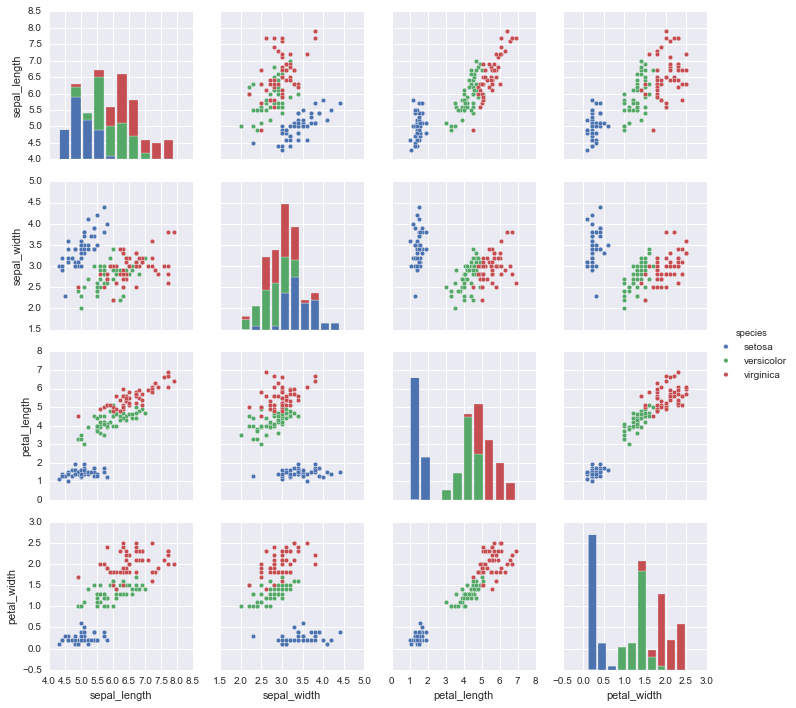

In [6]:
import seaborn as sns
sns.pairplot(data_df, hue='species')

# Shuffle the Columns and Split Train and Test Data

In [9]:
np.random.shuffle(data_df.values)
test_df = data_df.groupby(by='species').head(10)

In [10]:
train_df = data_df.iloc[data_df.index.difference(test_df.index)]
train_df.species.value_counts()

virginica     40
versicolor    40
setosa        40
Name: species, dtype: int64

In [11]:
import tensorflow as tf

In [12]:
# Helper function to make feed dict

def make_feed_dict(X, y, df):
    features = df.drop('species', axis=1).values
    labels = df.species.cat.codes
    labels_2d = np.atleast_2d(labels).T
    
    return {X: features, y: labels_2d}

# Set up TensorFlow Layers and Train

In [29]:
tf.reset_default_graph()

# Shape of X: n_training_rows * 4 cols
# Shape of y:n_training_rows * 1 col 
with tf.variable_scope('input'):
    X = tf.placeholder(name='X', shape=(None, 4), dtype=np.float64)
    y = tf.placeholder(name='y', shape=(None, 1), dtype=np.int64)

# Shape of w: 4 rows (n_cols from last layer) * 3 cols (n_classes) 
with tf.variable_scope('hidden'):
    w = tf.get_variable(name='w', 
                        shape=(4, 3),  
                        initializer=tf.truncated_normal_initializer(),
                       dtype=np.float64)
    
    b = tf.get_variable(name='b', 
                        shape=1,  
                        initializer=tf.constant_initializer(1.0),
                       dtype=np.float64)
    
    hidden = tf.add(tf.matmul(X, w), b, name='hidden')
    
# The softmax layer calculates cross-entropy error 
# between the softmaxed output of the hidden layer 
# and the one-hot encoded train labels
with tf.variable_scope('cross_entropy'):
    one_hot = tf.one_hot(indices=y, depth=3, name='one_hot')
    
    x_ent = tf.nn.softmax_cross_entropy_with_logits(
            labels=one_hot, 
            name='cross_entropy_error', 
            logits=hidden)
    
    loss_function = tf.reduce_mean(x_ent, name='loss')

with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.02)
    train_op = optimizer.minimize(loss_function)
    
n_iter = 1000
init_op = tf.global_variables_initializer()
loss_values = np.zeros(n_iter)

from IPython.display import display
from ipywidgets import FloatProgress

progress = FloatProgress(min=0, max=n_iter, description='Running training loop..')
display(progress)

with tf.Session() as sess:
    sess.run(init_op)

    train_dict = make_feed_dict(X, y, train_df)
    for i in range(1, n_iter+1):        
        _, current_loss = sess.run([train_op, loss_function], feed_dict=train_dict)       
        loss_values[i-1] = current_loss
        
        progress.value += 1
        
    progress.bar_style = 'Success'
    progress.description = 'Training complete.'
    
    # Evaluate with test data
    test_dict = make_feed_dict(X, y, test_df)
    test_preds = tf.argmax(tf.nn.softmax(hidden), axis=1, name='test_preds')
    test_results = sess.run(test_preds, feed_dict=test_dict)
    

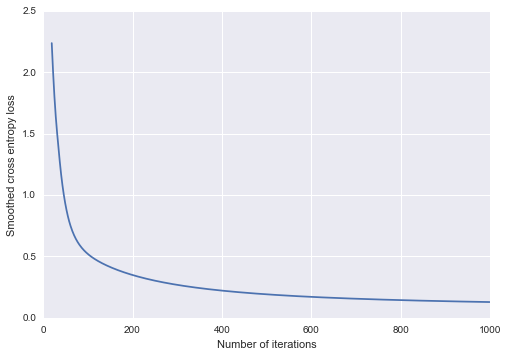

In [30]:
loss_values = pd.Series(loss_values, name='cross_entropy_loss')
ax = loss_values.rolling(window=20).mean().plot()
ax.set(xlabel='Number of iterations', ylabel='Smoothed cross entropy loss')

In [31]:
# Label codes for the IRIS species
test_results

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [39]:
predicted_labels = np.apply_along_axis(lambda idx: data_df.species.cat.categories[idx], 0, test_results)
actual_labels = test_df.species

labels = pd.unique(data_df.species)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(predicted_labels, actual_labels.values, labels=labels)
cm = pd.DataFrame(cm, index=labels, columns=labels)

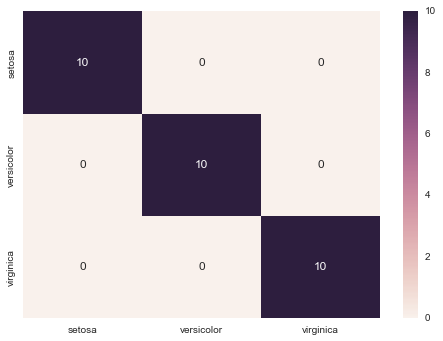

In [40]:
sns.heatmap(cm, annot=True)

# Appendix: Cross Entopy Error

Let's say at any given time, we have a batch of 5 training examples. Each example contains 4 features for 3 classes (same as in the IRIS problem).

The output layer of 3 nodes will then produce a $5*3$ matrix.

In [63]:
out = np.random.rand(5, 3)
out

array([[ 0.91804477,  0.93496251,  0.23093528],
       [ 0.6539292 ,  0.77752673,  0.86195378],
       [ 0.89837069,  0.98221402,  0.40337227],
       [ 0.4002789 ,  0.58142488,  0.24842138],
       [ 0.19059925,  0.78464687,  0.7392134 ]])

Each row is then softmaxed into a probability distribution:

In [64]:
def naive_softmax(row):
    return np.exp(row) / np.sum(np.exp(row))

In [65]:
q = np.apply_along_axis(naive_softmax, 1, out)

In [66]:
q

array([[ 0.39681128,  0.40358154,  0.19960718],
       [ 0.2973709 ,  0.33649313,  0.36613597],
       [ 0.37077817,  0.40320588,  0.22601595],
       [ 0.32704312,  0.39199065,  0.28096623],
       [ 0.22015968,  0.39877635,  0.38106397]])

This is the model predicted distribution.

In [67]:
np.sum(q, axis=1)

array([ 1.,  1.,  1.,  1.,  1.])

Now, we also have 5 1-hot encoded training labels, corresponding to 3 classes. This is true distribution.

In [68]:
p = np.array([
    [1, 0, 0],
    [1, 0, 0],
    [0, 0, 1],
    [0, 1, 0],
    [0, 0, 1],
])

The cross entropy error for example 1 is 

$- \sum_i p_i \space ln \space (q_i)$

In [73]:
-np.sum(p[0, :] * np.log(q[0, :]))

0.92429447200507864

Our goal is to build a model that's as close to the true distribution as possible. In that case, the value of q (for the 1st example) would be something like:

In [75]:
ideal_q1 = np.array([1 - 2E-5, 1E-5, 1E-5])

And the corresponding cross-entropy error is:

In [76]:
-np.sum(p[0, :] * np.log(ideal_q1))

2.0000200002686709e-05

In other words, minimizing the cross-entropy error leads to a model that closely approximates the true distribution.

Since we have a number of training examples, we calculate the cross entropy error of each sample and choose to minimize the mean, as in the case of MSE for regression problems.

In [82]:
xent_sum = -np.sum(p * np.apply_along_axis(np.log, 1, q), axis=1)
np.mean(xent_sum)

1.1051049173025631